Alex, a VP at a trading desk, wants to trade natural gas storage contracts, but the market data lacks sufficient granularity.

My task is to:

*   Analyze the monthly price data for natural gas from October 2020 to September 2024.
*   Estimate the price on any specific date in the past.
*   Extrapolate prices for an additional year to support longer-term contracts.
*   The analysis must account for seasonal trends based on months of the year.

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, timedelta
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [3]:
df = pd.read_csv('Nat_Gas.csv')
df.head(5)

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [28]:
# Get information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Dates   48 non-null     datetime64[ns]
 1   Prices  48 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 896.0 bytes
None


In [13]:
df['Dates'] = pd.to_datetime(df['Dates'])

<ipython-input-13-4454d6f9169b>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dates'] = pd.to_datetime(df['Dates'])


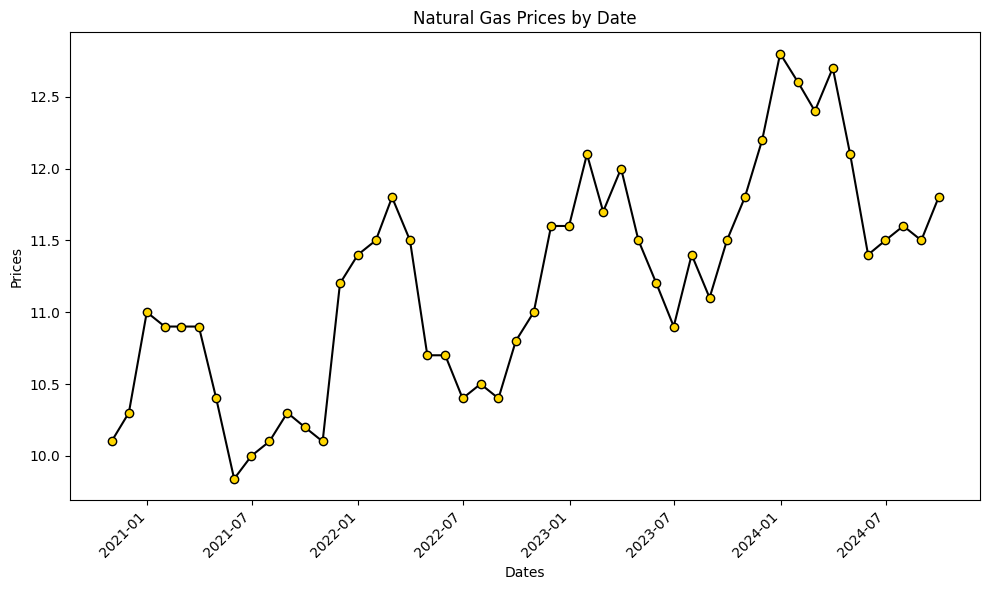

In [46]:
# Visualize the data

plt.figure(figsize=(10,6))
plt.plot(df['Dates'], df['Prices'], marker='o', color='black', markerfacecolor='gold')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Natural Gas Prices by Date')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

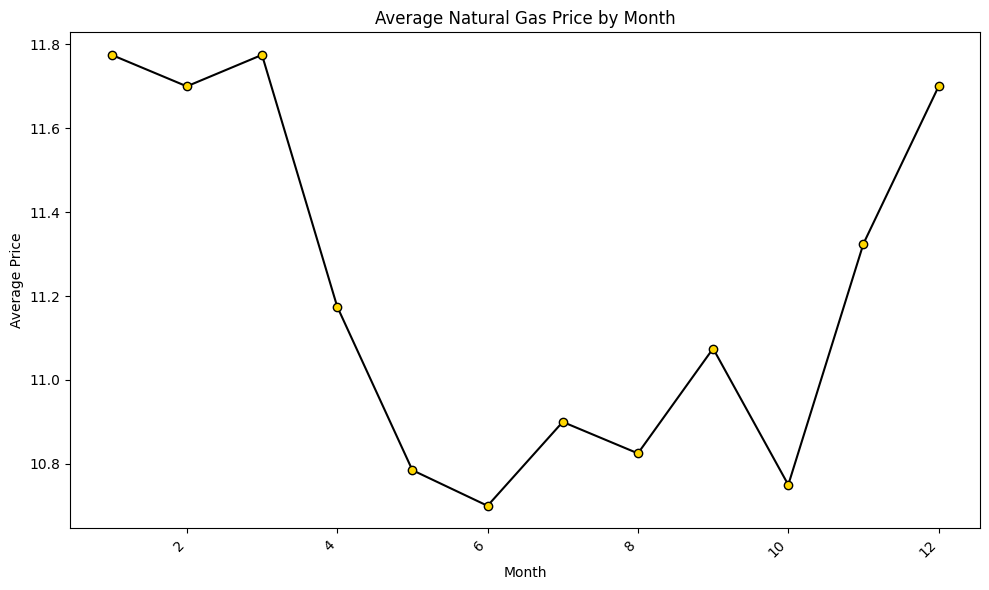

In [47]:
#  Seasonal Pattern Analysis

# Extract month from the 'Dates' column
df['Month'] = df['Dates'].dt.month

# Calculate average price for each month
monthly_avg_price = df.groupby('Month')['Prices'].mean()

# Plot the average price for each month using a line plot
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_price.index, monthly_avg_price.values,
         marker='o', color='black', markerfacecolor='gold')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.title('Average Natural Gas Price by Month')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Next, we need to interpolate the monthly data to daily data. Interpolation is a statistical method used to estimate values between known data points. In our case, we'll use it to estimate daily natural gas prices based on the monthly data.

For this task, we can consider:


*   Linear Interpolation: This method assumes a linear relationship between data points. It's a simple and efficient method, but it might not capture complex patterns.
*   Spline Interpolation: This method fits a smooth curve through the data points, often providing more accurate results, especially for non-linear trends.

In [82]:
# Create a DatetimeIndex for daily dates
daily_index = pd.date_range(start=df['Dates'].min(),
                            end=df['Dates'].max(),
                            freq='D')

# Reindex the DataFrame with the daily index
df_daily = df.set_index('Dates').reindex(daily_index)

# Interpolate the missing daily values using linear interpolation
df_daily['Prices'] = df_daily['Prices'].interpolate(method='linear')

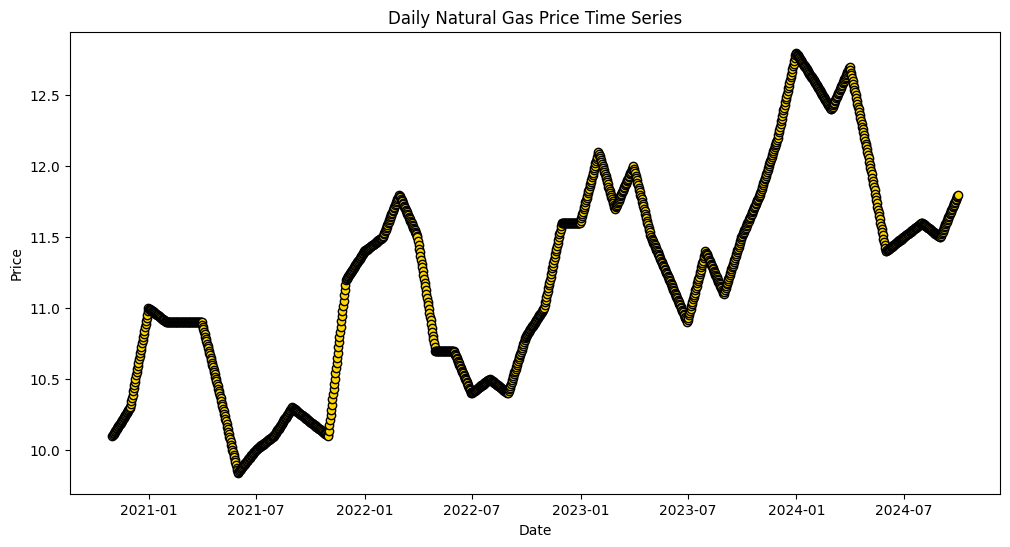

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, df_daily['Prices'], marker='o', color='black', markerfacecolor='gold')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Daily Natural Gas Price Time Series')
plt.show()

In [ ]:
# Interpolate the missing daily values using spline interpolation
df_daily = df.set_index('Dates').reindex(daily_index)
df_daily['Prices'] = df_daily['Prices'].interpolate(method='spline', order=2)

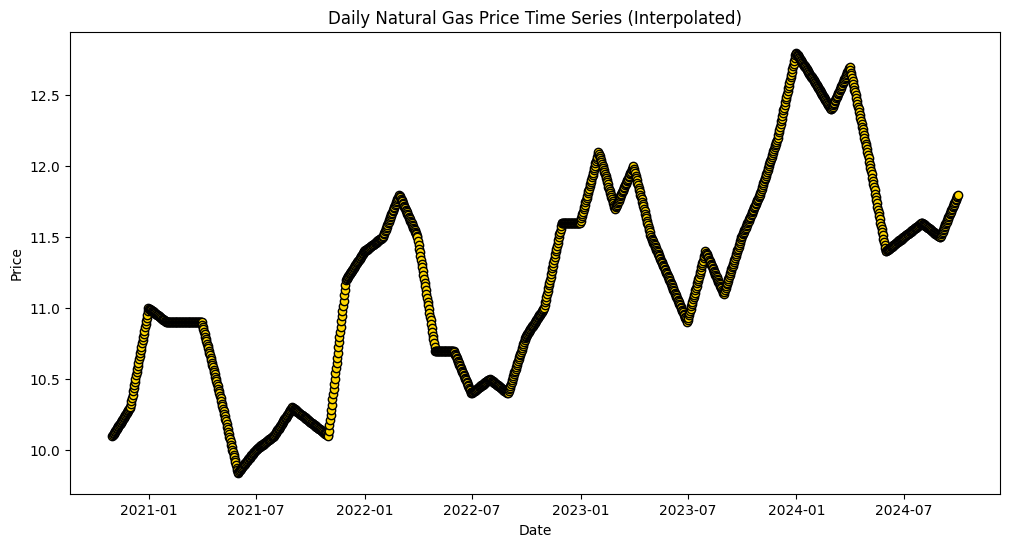

In [54]:
# Plot both interpolated series
plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, df_daily['Prices'],  marker='o', color='black', markerfacecolor='gold', label='Spline Interpolation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Daily Natural Gas Price Time Series (Interpolated)')
plt.show()

In [85]:
# Fit the model
model = ExponentialSmoothing(df_daily['Prices'], seasonal='add', seasonal_periods=365)
fit = model.fit()

In [86]:
# Forecast for one year into the future
forecast_steps = 365
forecast = fit.forecast(forecast_steps)

# Create a date range for the forecast
forecast_dates = pd.date_range(start=df_daily.index.max() + timedelta(days=1),
                               periods=forecast_steps, freq='D')

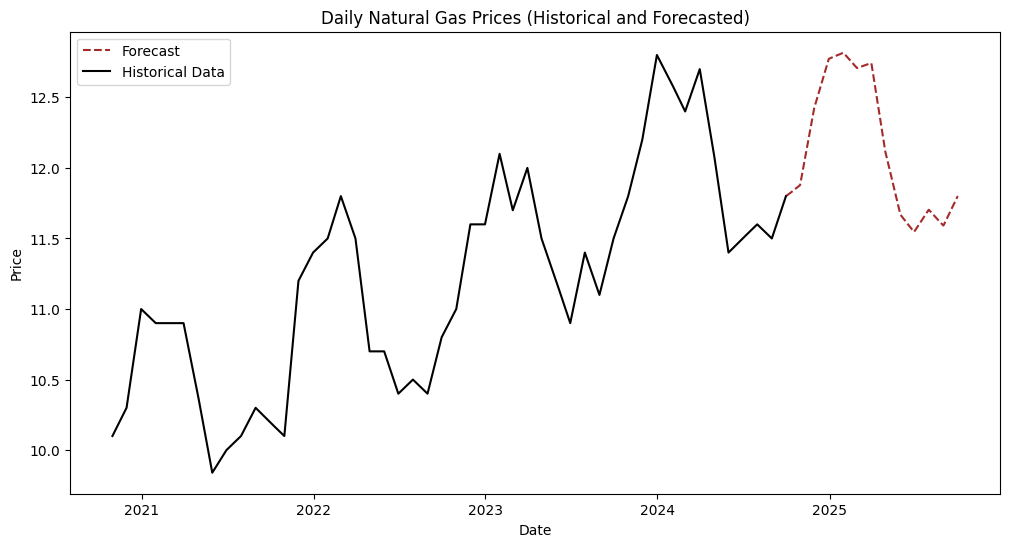

In [101]:
# Combine the historical and forecasted data
forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=['Price'])
combined_data = pd.concat([df_daily, forecast_df])

# Visualize the combined data
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data['Price'],
         linestyle='--', color='brown', label='Forecast')
plt.plot(df_daily.index, df_daily['Prices'], color='black', label='Historical Data')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Daily Natural Gas Prices (Historical and Forecasted)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Finally, we create a function to estimate the price for any given date.

In [88]:
def estimate_price(date):
    date = pd.to_datetime(date)
    if date in combined_data.index:
        return combined_data.loc[date, 'Price']
    else:
        return np.nan

In [92]:
enter_date = '2024-12-01'
estimated_price = "{:.2f}".format(estimate_price(enter_date))
print(f"The estimated price on {enter_date} is: {estimated_price}")

The estimated price on 2024-12-01 is: 12.45
